## Multi-Information Source BO with Augmented Gaussian Processes

In this tutorial, we show how to perform multi-information source Bayesian optimization in BoTorch using the Augmented Gaussian Process (AGP) along with the Augmented UCB (AUCB) acquisition function [1]. The key idea of AGP is to fit a GP model for each information source and *augment* the GP of the high fidelity source with observations from the lower fidelities sources. Only observations considered as *reliable* are used to augment the GP. The UCB acquisition function is modified to take into account also the sources' cost.

We find the AGP performs well if compared with discrete multi-fidelity approaches [2].

[1] [Candelieri, A., & Archetti, F. (2021). Sparsifying to optimize over multiple information sources: an augmented Gaussian process based algorithm. Structural and Multidisciplinary Optimization, 64, 239-255.](https://link.springer.com/article/10.1007/s00158-021-02882-7)
[2] [The arxiv will be available soon.](https://arxiv.org/)


In [1]:
!pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import matplotlib.pyplot as plt

import torch
from gpytorch import ExactMarginalLogLikelihood

import botorch
from botorch import fit_gpytorch_mll
from botorch.acquisition import InverseCostWeightedUtility, qMultiFidelityMaxValueEntropy
from botorch.acquisition.augmented_multisource import AugmentedUpperConfidenceBound
from botorch.models import AffineFidelityCostModel, SingleTaskMultiFidelityGP
from botorch.models.gp_regression_multisource import SingleTaskAugmentedGP, get_random_x_for_agp
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf, optimize_acqf_mixed
from botorch.test_functions.multi_fidelity import AugmentedBranin

In [3]:
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST", False)

In [4]:
N_ITER = 10 if SMOKE_TEST else 50
SEED = 3

### Problem setup
We'll consider the Augmented Branin multi-fidelity synthetic test problem. This function is a version of the Branin test function with an additional dimension representing the fidelity parameter. The function takes the form $f(x,s)$ where $x \in [-5, 10] \times [0, 15]$ and $s \in [0,1]$. The target fidelity is 1.0, which means that our goal is to solve $\max_x f(x,1.0)$ by making use of cheaper evaluations $f(x,s)$ for $s < 1.0$. In this example, we'll assume that the cost function takes the form $5.0 + s$, illustrating a situation where the fixed cost is $5.0$.

Since a multi-information source context is considered, three different sources we'll be used with $s = 0.5, 0.75, 1.00$ respectively.

In [5]:
problem = AugmentedBranin(negate=True).to(**tkwargs)
fidelities = torch.tensor([0.5, 0.75, 1.0], **tkwargs)
n_sources = fidelities.shape[0]

bounds = torch.tensor([[-5, 0, 0], [10, 15, n_sources - 1]], **tkwargs)
target_fidelities = {n_sources - 1: 1.0}

cost_model = AffineFidelityCostModel(fidelity_weights=target_fidelities, fixed_cost=5.0)
cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

### Model initialization

We use a `SingleTaskAugmentedGP` to implement our AGP.

At each Bayesian Optimization iteration, the set of observations from the *ground-truth* (i.e., the highest fidelity and more expensive source) is temporarily *augmented* by including observations from the other cheap sources, only if they can be considered *reliable*. Specifically, an observation $(x,y)$ from a cheap source is considered reliable if it satisfies the following inequality:

$$\vert\mu(x)-y\vert \leq m \sigma(x)$$

where $\mu(x)$ and $\sigma(x)$ are, respectively, the posterior mean and standard deviation of the GP model fitted on the high fidelity observations only, and $m$ is a technical parameter making more *conservative* ($m→0$) or *inclusive* ($m→∞)$ the augmentation process. As reported in [1], a suitable value for this parameter is $m=1$.

After the set of observations is augmented, the AGP is fitted through `SingleTaskAugmentedGP`.


In [6]:
def generate_initial_data(n):
    train_x = get_random_x_for_agp(n, bounds, 1)
    xs = train_x[..., :-1]
    fids = fidelities[train_x[..., -1].int()].reshape(-1, 1)
    train_obj = problem(torch.cat((xs, fids), dim=1)).unsqueeze(-1)
    return train_x, train_obj


def initialize_model(train_x, train_obj, m):
    model = SingleTaskAugmentedGP(
        train_x, train_obj, m=m, outcome_transform=Standardize(m=1),
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

#### Define a helper function that performs the essential BO step
This helper function optimizes the acquisition function and returns the candidate point along with the observed function values.

The UCB acquisition function has been modified to deal with both the *discrepancy* between information sources and the *source-specific query cost*.

Formally, the AUCB acquisition function, at a generic iteration $t$, is defined as:

$$\alpha_s(x,\hat y^+) = \frac{\left[\hat{\mu}(x) + \sqrt{\beta^{(t)}} \hat{\sigma}(x)\right] - \hat{y}^+}{c_s \cdot (1+\vert \hat{\mu}(x) - \mu_s(x) \vert)} $$

where $\hat{y}^+$ is the best (i.e., highest) value in the *augmented* set of observations, the numerator is -- therefore -- the optimistic improvement with respect to $\hat{y}^+$, $c_s$ is the query cost for the source $s$, and $\vert \hat{\mu}(x) - \mu_s(x) \vert$ is a discrepancy measure between the predictions provided by the AGP and the GP on the source $s$, respectively, given the input $x$ (i.e., 1 is added just to avoid division by zero).

For more information, please refer to [1],

In [7]:
def optimize_aucb(acqf):
    candidate, value = optimize_acqf(
        acq_function=acqf,
        bounds=bounds,
        q=1,
        num_restarts=5,
        raw_samples=128,
    )
    # observe new values
    new_x = candidate.detach()
    new_x[:, -1] = torch.round(new_x[:, -1], decimals=0)
    return new_x

### Perform a few steps of multi-fidelity BO
First, let's generate some initial random data and fit a surrogate model.

In [8]:
torch.manual_seed(SEED)
train_x, train_obj = generate_initial_data(n=5)

We can now use the helper functions above to run a few iterations of BO.

In [9]:
cumulative_cost = 0.0

with botorch.settings.validate_input_scaling(False):
    for it in range(N_ITER):
        mll, model = initialize_model(train_x, train_obj, m=1)
        fit_gpytorch_mll(mll)
        acqf = AugmentedUpperConfidenceBound(
            model,
            beta=3,
            maximize=True,
            best_f=train_obj[torch.where(train_x[:, -1] == 0)].min(),
            cost={i: fid + 5.0 for i, fid in enumerate(fidelities)},
        )
        new_x = optimize_aucb(acqf)
        if model.n_true_points < model.max_n_cheap_points:
            new_x[:, -1] = fidelities.shape[0] - 1
        train_x = torch.cat([train_x, new_x])

        new_x[:, -1] = fidelities[new_x[:, -1].int()]
        new_obj = problem(new_x).unsqueeze(-1)
        train_obj = torch.cat([train_obj, new_obj])

        print(
            f"Iter {it};"
            f"\t Fid = {new_x[0].tolist()[-1]:.2f};"
            f"\t Obj = {new_obj[0][0].tolist():.4f};"
        )

Iter 0;	 Fid = 1.00;	 Obj = -12.0999;
Iter 1;	 Fid = 1.00;	 Obj = -50.0743;
Iter 2;	 Fid = 0.50;	 Obj = -11.9672;
Iter 3;	 Fid = 0.50;	 Obj = -8.7046;
Iter 4;	 Fid = 0.50;	 Obj = -13.3425;
Iter 5;	 Fid = 1.00;	 Obj = -11.6850;
Iter 6;	 Fid = 0.50;	 Obj = -8.2926;
Iter 7;	 Fid = 1.00;	 Obj = -14.4455;
Iter 8;	 Fid = 0.50;	 Obj = -16.5712;
Iter 9;	 Fid = 1.00;	 Obj = -32.4978;
Iter 10;	 Fid = 0.50;	 Obj = -17.8776;
Iter 11;	 Fid = 1.00;	 Obj = -17.4798;
Iter 12;	 Fid = 0.50;	 Obj = -14.4403;
Iter 13;	 Fid = 1.00;	 Obj = -16.5080;
Iter 14;	 Fid = 0.50;	 Obj = -48.2065;
Iter 15;	 Fid = 1.00;	 Obj = -67.0580;
Iter 16;	 Fid = 0.50;	 Obj = -113.7052;
Iter 17;	 Fid = 1.00;	 Obj = -5.5352;
Iter 18;	 Fid = 1.00;	 Obj = -14.0937;
Iter 19;	 Fid = 0.50;	 Obj = -116.5878;
Iter 20;	 Fid = 1.00;	 Obj = -5.2398;
Iter 21;	 Fid = 1.00;	 Obj = -2.9797;
Iter 22;	 Fid = 1.00;	 Obj = -0.9191;
Iter 23;	 Fid = 1.00;	 Obj = -0.4690;
Iter 24;	 Fid = 1.00;	 Obj = -2.7735;
Iter 25;	 Fid = 1.00;	 Obj = -5.6576;
Ite

## Comparison to MES

In [10]:
def initialize_mes_model(train_x, train_obj, data_fidelity):
    model = SingleTaskMultiFidelityGP(
        train_x,
        train_obj,
        outcome_transform=Standardize(m=1),
        data_fidelity=data_fidelity,
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

In [11]:
def optimize_mes_and_get_observation(mes_acq, fixed_features_list):
    candidates, acq_value = optimize_acqf_mixed(
        acq_function=mes_acq,
        bounds=problem.bounds,
        q=1,
        num_restarts=5,
        raw_samples=128,
        fixed_features_list=fixed_features_list,
    )
    # observe new values
    cost = cost_model(candidates).sum()
    new_x = candidates.detach()
    new_obj = problem(new_x).unsqueeze(-1)
    return new_x, new_obj, cost

In [12]:
train_x_mes = torch.clone(train_x[:10])
train_x_mes[:, -1] = fidelities[train_x_mes[:, -1].int()]
train_obj_mes = torch.clone(train_obj[:10])

In [13]:
candidate_set = torch.rand(
    1000, problem.bounds.size(1), device=problem.bounds.device, dtype=problem.bounds.dtype
)
candidate_set = problem.bounds[0] + (problem.bounds[1] - problem.bounds[0]) * candidate_set

cumulative_cost = 0.0

with botorch.settings.validate_input_scaling(False):
    for it in range(N_ITER):
        mll, model = initialize_mes_model(train_x_mes, train_obj_mes, data_fidelity=2)
        fit_gpytorch_mll(mll)
        acqf = qMultiFidelityMaxValueEntropy(
            model, candidate_set, cost_aware_utility=cost_aware_utility
        )
        new_x, new_obj, cost = optimize_mes_and_get_observation(acqf,
                                                                fixed_features_list=[{2: fid} for fid in fidelities])
        train_x_mes = torch.cat([train_x_mes, new_x])
        train_obj_mes = torch.cat([train_obj_mes, new_obj])
        cumulative_cost += cost
        print(
            f"Iter {it};"
            f"\t Fid = {new_x[0].tolist()[-1]:.2f};"
            f"\t Obj = {new_obj[0][0].tolist():.4f};"
        )

Iter 0;	 Fid = 0.50;	 Obj = -57.5522;
Iter 1;	 Fid = 0.50;	 Obj = -45.4163;
Iter 2;	 Fid = 0.50;	 Obj = -9.0258;
Iter 3;	 Fid = 1.00;	 Obj = -48.1935;
Iter 4;	 Fid = 0.50;	 Obj = -0.9326;
Iter 5;	 Fid = 0.50;	 Obj = -80.6658;
Iter 6;	 Fid = 0.50;	 Obj = -2.1240;
Iter 7;	 Fid = 0.50;	 Obj = -10.3696;
Iter 8;	 Fid = 0.50;	 Obj = -4.4469;
Iter 9;	 Fid = 0.50;	 Obj = -8.9561;
Iter 10;	 Fid = 0.50;	 Obj = -22.0102;
Iter 11;	 Fid = 0.50;	 Obj = -16.9033;
Iter 12;	 Fid = 0.50;	 Obj = -13.5406;
Iter 13;	 Fid = 0.75;	 Obj = -0.6079;
Iter 14;	 Fid = 0.50;	 Obj = -31.6025;
Iter 15;	 Fid = 0.50;	 Obj = -38.2686;
Iter 16;	 Fid = 0.50;	 Obj = -17.9994;
Iter 17;	 Fid = 0.50;	 Obj = -19.7949;
Iter 18;	 Fid = 0.50;	 Obj = -275.5655;
Iter 19;	 Fid = 0.50;	 Obj = -111.8389;
Iter 20;	 Fid = 0.50;	 Obj = -91.2188;
Iter 21;	 Fid = 0.50;	 Obj = -76.4585;
Iter 22;	 Fid = 0.50;	 Obj = -0.5961;
Iter 23;	 Fid = 0.50;	 Obj = -14.7103;
Iter 24;	 Fid = 0.50;	 Obj = -2.7677;
Iter 25;	 Fid = 0.50;	 Obj = -53.0683;
It

## Plot results

In [14]:
mapping_fid = dict(zip(range(fidelities.shape[0]), fidelities.tolist()))
cost_AGP = torch.cumsum(torch.tensor([mapping_fid[int(source)] for source in train_x[:, -1].tolist()]), dim=0)
cost_MES = torch.cumsum(train_x_mes[:, -1], dim=0)

In [15]:
train_obj[torch.where(train_x[:, -1] != fidelities.shape[0] - 1)] = train_obj.min()
best_seen_AGP = torch.cummax(train_obj, dim=0)[0]

In [16]:
train_obj_mes[torch.where(train_x_mes[:, -1] != 1)[0]] = train_obj_mes.min()
best_seen_MES = torch.cummax(train_obj_mes, dim=0)[0]

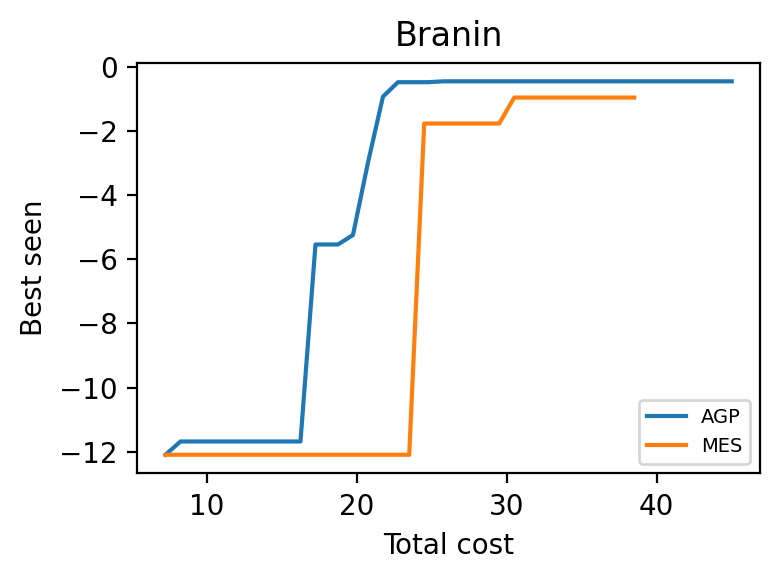

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=200)
ax.plot(
    cost_AGP[9:],
    best_seen_AGP[9:],
    label="AGP"
)
ax.plot(
    cost_MES[9:],
    best_seen_MES[9:],
    label="MES"
)

ax.set_title("Branin", fontsize="12")
ax.set_xlabel("Total cost", fontsize="10")
ax.set_ylabel("Best seen", fontsize="10")
ax.tick_params(labelsize=10)
ax.legend(loc="lower right", fontsize="7", frameon=True, ncol=1)
plt.tight_layout()